In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install geopy
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 28.7 MB/s 
     |████████████████████████████████| 16.7 MB 47.4 MB/s 
     |████████████████████████████████| 6.3 MB 61.4 MB/s 


In [1]:
## Загрузим нужные библиотеки

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

from sklearn.metrics import recall_score, r2_score

from geopy.exc import GeocoderTimedOut
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopandas.tools import geocode

%matplotlib inline
# progress bar
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

In [123]:
df = pd.read_csv("/content/drive/MyDrive/train_dataset_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/test_dataset_test.csv")

# , nrows = 10000)

In [124]:
## Рассмотрим датасет поближе

df.head(3)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022


In [125]:
# df[df['station_nm'] == 'Авиамоторная']

In [126]:
# pd.DataFrame(df.groupby(['station_id'])['label'].agg(pd.Series.mode)).reset_index()

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091021 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091021 non-null  int64  
 1   ticket_id       1091021 non-null  object 
 2   ticket_type_nm  1091021 non-null  object 
 3   entrance_id     1091021 non-null  int64  
 4   entrance_nm     1091021 non-null  object 
 5   station_id      1091021 non-null  int64  
 6   station_nm      1091021 non-null  object 
 7   line_id         1091021 non-null  int64  
 8   line_nm         1091021 non-null  object 
 9   pass_dttm       1091021 non-null  object 
 10  time_to_under   1091021 non-null  float64
 11  label           1091021 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 99.9+ MB


In [128]:
# Видоизменим категорию **"pass_dttm"**  

df["day"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
df["hours"] = df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

df_test["day"] = df_test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))
df_test["hours"] = df_test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

In [129]:
# Добавим новый столбец в датсет и взглянем на то что у нас получилось

df.head(3)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,12,5
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,12,5


In [130]:
df['date'] = pd.to_datetime(pd.DataFrame({'year': df['pass_dttm'].map(lambda x: int(x[0:4])),
                   'month': df['pass_dttm'].map(lambda x: int(x[5:7])),
                   'day': df.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))}))

df_test['date'] = pd.to_datetime(pd.DataFrame({'year': df_test['pass_dttm'].map(lambda x: int(x[0:4])),
                   'month': df_test['pass_dttm'].map(lambda x: int(x[5:7])),
                   'day': df_test.pass_dttm.map(lambda x: int(x.split("-")[2].split(" ")[0]))}))

In [131]:
df['is_weekend'] = [1 if i.weekday() in [6,7]  else 0 for i in df["date"]]
df_test['is_weekend'] = [1 if i.weekday() in [6,7]  else 0 for i in df_test["date"]]

In [132]:
df['ticket_type_nm'].unique().tolist()

['Пропуск FacePay',
 'СК учащегося 30 дней',
 'БСК дружинника г.Москвы',
 '30 дней',
 'КОШЕЛЕК',
 'СК студента 30 дней',
 '90 дней',
 '90 дней ЕДИНЫЙ ТК',
 '30 дней СК учащегося',
 '90 дней СК студента',
 '30 дней СК студента',
 'ББК',
 'СК аспиранта 90 дней',
 'Социальная карта москвича',
 '30 дней ЕДИНЫЙ ТК',
 'Социальная карта жителя Моск. области',
 '30 дней Пригород ТК',
 'Социальная карта москвича с сопровождающим',
 'Пропуск сотрудника УВД по охране Метрополитена',
 '60 поездок ЕДИНЫЙ ТК',
 'СК для сотрудника ГУВД г.Москвы',
 '365 дней ЕДИНЫЙ ТК',
 'ВЕСБ МОСКВА (7мин)',
 'СК студента 90 дней',
 '90 дней Пригород ТК',
 '30 дней  Пригород',
 '365 дней Пригород ТК',
 '365 дней',
 'СК ординатора 30 дней',
 '30 дней СК аспиранта',
 '30 дней СК ординатора',
 '90 дней СК ординатора',
 'ВЕСБ МО (7 мин)',
 'ВЕСБ МО (тип 5)',
 'СК ординатора 90 дней',
 'СК аспиранта 30 дней',
 '90 дней СК учащегося',
 'Временный билет ММ',
 'Социальная карта жителя Моск. области с сопровождающим',
 'СК уч

In [133]:
df['unlimited_ticket'] = [0 if i in(['КОШЕЛЕК', 'ББК','60 поездок ЕДИНЫЙ ТК', 'Пропуск FacePay','Безналичная транспортная карта']) else 1 for i in df['ticket_type_nm']]
df['MO_ticket'] = [1 if i in(['30 дней Пригород ТК','30 дней  Пригород','365 дней Пригород ТК', '90 дней Пригород ТК', 'ВЕСБ МО (тип 5)', 'ВЕСБ МО (7 мин)', '90 дней  Пригород', '365 дней  Пригород']) else 0 for i in df['ticket_type_nm']]
df['student_ticket'] = [1 if i in(['СК учащегося 30 дней', '30 дней СК учащегося', '30 дней СК студента','СК студента 30 дней', 'СК аспиранта 30 дней', 'СК студента 90 дней','СК учащегося 90 дней', '90 дней СК учащегося','30 дней СК аспиранта', '90 дней СК студента', 'СК аспиранта 90 дней', '90 дней СК аспиранта']) else 0 for i in df['ticket_type_nm']]
df['social_ticket'] = [1 if i in(['Социальная карта москвича', 'Социальная карта жителя Моск. области', 'Социальная карта москвича с сопровождающим', 'ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)', 'Социальная карта жителя Моск. области с сопровождающим','ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим', 'ВЕСБ МО (тип 6)']) else 0 for i in df['ticket_type_nm']]

df_test['unlimited_ticket'] = [0 if i in(['КОШЕЛЕК', 'ББК','60 поездок ЕДИНЫЙ ТК', 'Пропуск FacePay','Безналичная транспортная карта']) else 1 for i in df_test['ticket_type_nm']]
df_test['MO_ticket'] = [1 if i in(['30 дней Пригород ТК','30 дней  Пригород','365 дней Пригород ТК', '90 дней Пригород ТК', 'ВЕСБ МО (тип 5)', 'ВЕСБ МО (7 мин)', '90 дней  Пригород', '365 дней  Пригород']) else 0 for i in df_test['ticket_type_nm']]
df_test['student_ticket'] = [1 if i in(['СК учащегося 30 дней', '30 дней СК учащегося', '30 дней СК студента','СК студента 30 дней', 'СК аспиранта 30 дней', 'СК студента 90 дней','СК учащегося 90 дней', '90 дней СК учащегося','30 дней СК аспиранта', '90 дней СК студента', 'СК аспиранта 90 дней', '90 дней СК аспиранта']) else 0 for i in df_test['ticket_type_nm']]
df_test['social_ticket'] = [1 if i in(['Социальная карта москвича', 'Социальная карта жителя Моск. области', 'Социальная карта москвича с сопровождающим', 'ВЕСБ МО (7 мин)', 'ВЕСБ МО (тип 5)', 'Социальная карта жителя Моск. области с сопровождающим','ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим', 'ВЕСБ МО (тип 6)']) else 0 for i in df_test['ticket_type_nm']]

In [134]:
temp = pd.DataFrame(df.groupby(['is_weekend', 'hours','station_nm'])['label'].agg(pd.Series.mode)).reset_index()
temp = temp.rename(columns={"label": "label_mode"})

for ind, i in enumerate(temp['label_mode']):
    try:
      x = len(i)
      temp['label_mode'][ind] = i[0]
    except TypeError:
      pass

temp["label_mode"] = temp["label_mode"].astype('int16')

df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [32]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['time_to_under'].mean()).reset_index()
temp = temp.rename(columns={"time_to_under": "avg_time"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [136]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['time_to_under'].min()).reset_index()
temp = temp.rename(columns={"time_to_under": "min_time"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [137]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['time_to_under'].max()).reset_index()
temp = temp.rename(columns={"time_to_under": "max_time"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [34]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend', 'hours','station_nm'])['label'].agg(pd.Series.mode)).reset_index()
temp = temp.rename(columns={"label": "label_mode_ticket_type"})

for ind, i in enumerate(temp['label_mode_ticket_type']):
    try:
      x = len(i)
      temp['label_mode_ticket_type'][ind] = i[0]
    except TypeError:
      pass

temp["label_mode_ticket_type"] = temp["label_mode_ticket_type"].astype('int16')

df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [35]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['time_to_under'].mean()).reset_index()
temp = temp.rename(columns={"time_to_under": "avg_time_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [36]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['time_to_under'].min()).reset_index()
temp = temp.rename(columns={"time_to_under": "min_time_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [37]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['time_to_under'].max()).reset_index()
temp = temp.rename(columns={"time_to_under": "max_time_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [138]:
df_test

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time
0,1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,12,5,2022-09-12,0,0,0,0,0,6009,671.181944,113.666667,1050.366667
1,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,12,5,2022-09-12,0,1,0,1,0,6009,671.181944,113.666667,1050.366667
2,1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,12,5,2022-09-12,0,0,0,0,0,6009,671.181944,113.666667,1050.366667
3,1091028,9321EACCF373DBE622B8E8E642B2D445,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:03:46,12,5,2022-09-12,0,1,0,1,0,6009,671.181944,113.666667,1050.366667
4,1091031,4B9DC31708F3AD1DF71CEAF8C1B3FCB4,30 дней ЕДИНЫЙ ТК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:08:53,12,5,2022-09-12,0,1,0,0,0,6009,671.181944,113.666667,1050.366667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561524,1652903,77AAD9565EADD05D9EEBF97AB51EE538,Пропуск FacePay,340,Тушинская (Первый),7021,Тушинская,7,Таганско-Краснопресненская,2022-09-19 01:05:28,19,1,2022-09-19,0,0,0,0,0,7021,31.050000,31.050000,31.050000
561525,1652904,CD4C8D78480934EB9DACAC6AD21417EB,Пропуск FacePay,422,Марьино (Второй),10013,Марьино,10,Люблинско-Дмитровская,2022-09-19 01:09:19,19,1,2022-09-19,0,0,0,0,0,10013,85.350000,85.350000,85.350000
561526,1652906,E6B94F8C88A2BB1CEBF4614178E6DB75,Пропуск FacePay,106,Сокол ( Сев./Зап. ),2018,Сокол,2,Замоскворецкая,2022-09-19 01:13:35,19,1,2022-09-19,0,0,0,0,0,2018,444.744444,31.600000,883.983333
561527,1652907,B6FADEB8705FAF8E9DFD9016A613D997,Пропуск FacePay,279,Калужская (Южный),6007,Калужская,6,Калужско-Рижская,2022-09-19 01:33:11,19,1,2022-09-19,0,0,0,0,0,6007,357.166667,357.166667,357.166667


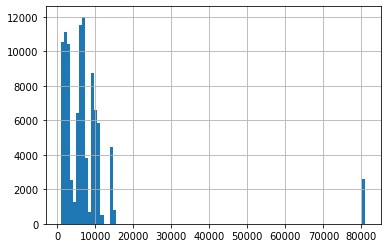

In [ ]:
# Посмотрим на распределение двух основных величин 

df["label"].hist(bins = 100);

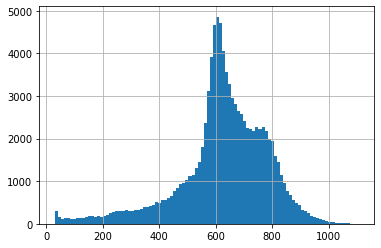

In [ ]:
df["time_to_under"].hist(bins = 100);

In [ ]:
# Найдем наиболее популярную станцию

df["label"].value_counts()

3002     1502
7022     1390
6008     1229
1022     1146
5009     1135
         ... 
14004      18
13001       2
13005       1
13004       1
13003       1
Name: label, Length: 274, dtype: int64

In [ ]:
df[df["label"] == int(df["label"].value_counts().index[0])].head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
60,61,764D546455E294FF9ACFB1A863A10E4B,Социальная карта жителя Моск. области,218,Новогиреево (Восточный),8003,Новогиреево,8,Калининская,2022-09-12 05:22:19,677.233333,3002
233,234,08C38EBE7D5FE076740767D284BC9461,90 дней ЕДИНЫЙ ТК,221,Перово (Восточный),8005,Перово,8,Калининская,2022-09-12 05:28:54,706.883333,3002
307,308,F13C0CD1665DC19E1344C679EDE629B3,30 дней ЕДИНЫЙ ТК,2227,Селигерская (Второй),10018,Селигерская,10,Люблинско-Дмитровская,2022-09-12 05:29:53,792.900000,3002
420,421,775F417B46D967439A38F3309F9F297C,30 дней ЕДИНЫЙ ТК,730,Дубровка,10007,Дубровка,10,Люблинско-Дмитровская,2022-09-12 05:30:24,290.266667,3002
526,527,402E9F04DAA4F79487D870516DE00CB5,КОШЕЛЕК,343,Сходненская (Первый),7018,Сходненская,7,Таганско-Краснопресненская,2022-09-12 05:30:53,829.166667,3002


In [ ]:
df

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.100000,216.316667
1,169985,EECA0DB8C5556CE0469E33A5F271EC78,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-13 05:09:19,159.300000,11007,13,5,2022-09-13,0,0,0,0,0,11007,119.403333,30.100000,216.316667
2,339855,4E94D9AD14B82D3BF1CA5FF2FBFEBEBC,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 05:24:36,144.183333,11007,14,5,2022-09-14,0,0,0,0,0,11007,119.403333,30.100000,216.316667
3,508742,F23D89C1BB41EA202A56EA687BC22418,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-15 05:31:24,47.116667,11009,15,5,2022-09-15,0,0,0,0,0,11007,119.403333,30.100000,216.316667
4,836615,EC54545DF96AD2A42400896E38305DF1,Социальная карта москвича,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-17 05:31:42,30.100000,3023,17,5,2022-09-17,0,1,0,0,1,11007,119.403333,30.100000,216.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,1091015,2B25F5003B4430F4D20DD2AD5199F07A,Пропуск FacePay,2241,Боровское шоссе (Второй),81014,Боровское шоссе,81,Солнцевская,2022-09-19 02:06:28,100.200000,81014,19,2,2022-09-19,0,0,0,0,0,15478,100.200000,100.200000,100.200000
1091017,1091016,09DF34835FB28E5AF5FF8CCA198A01D9,Пропуск FacePay,2102,Пятницкое шоссе (Второй),3016,Пятницкое шоссе,3,Арбатско-Покровская,2022-09-19 02:15:27,89.733333,3016,19,2,2022-09-19,0,0,0,0,0,3016,89.733333,89.733333,89.733333
1091018,1091017,6A738232F8E43DFCD4027FDC0EA6CC03,Пропуск FacePay,2283,Нижегородская (второй),15005,Нижегородская,15,Некрасовская,2022-09-19 02:54:50,124.750000,15005,19,2,2022-09-19,0,0,0,0,0,15005,124.750000,124.750000,124.750000
1091019,1091018,141174B366F14A8703903813A49374DB,Пропуск FacePay,278,Калужская (Северный),6007,Калужская,6,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007,19,3,2022-09-19,0,0,0,0,0,6007,56.066667,56.066667,56.066667


In [38]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')

In [77]:
df = pd.read_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv', index_col = 0)
df_test = pd.read_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv', index_col = 0)

In [139]:
df_zones = pd.DataFrame(df.groupby(['line_nm', 'station_nm'])['station_id'].min())

In [140]:
df_zones['zone'] = [
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
2, 
1, 
2, 
3, 
1, 
1, 
2, 
1, 
3, 
1, 
3, 
3, 
3, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
2, 
2, 
1, 
1, 
2, 
1, 
1, 
2, 
3, 
3, 
3, 
1, 
3, 
1, 
1, 
1, 
2, 
2, 
2, 
3, 
3, 
1, 
1, 
1, 
2, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
2, 
2, 
1, 
2, 
3, 
2, 
3, 
3, 
3, 
3, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
3, 
2, 
2, 
1, 
1, 
1, 
1, 
2, 
2, 
2, 
2, 
2, 
2, 
3, 
3, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
2, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
2, 
2, 
1, 
2, 
2, 
1, 
2, 
3, 
3, 
3, 
3, 
3, 
3, 
2, 
2, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
2, 
2, 
3, 
1, 
2, 
1, 
2, 
3, 
3, 
3, 
3, 
3, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
1, 
1, 
1, 
1, 
1, 
2, 
1, 
1, 
2, 
1, 
2, 
1, 
2, 
2, 
1, 
3, 
3, 
1, 
3, 
3, 
2, 
1, 
1, 
1, 
1, 
1, 
3, 
2, 
3, 
3, 
3, 
3
]

In [141]:
df_zones

station_id  zone
line_nm             station_nm                      
Арбатско-Покровская Арбатская             3001     1
                    Бауманская            3002     1
                    Волоколамская         3003     1
                    Измайловская          3004     1
                    Киевская              3005     1
...                                        ...   ...
Филёвская           Пионерская            4009     2
                    Смоленская            4010     3
                    Студенческая          4011     3
                    Фили                  4013     3
                    Филёвский парк        4012     3

[276 rows x 2 columns]

In [142]:
df = df.merge(df_zones, left_on=['station_id'], right_on=['station_id'])
df_test = df_test.merge(df_zones, left_on=['station_id'], right_on=['station_id'])

df = df.merge(df_zones, left_on=['label'], right_on=['station_id'])

In [143]:
sorted(df_test.columns.tolist())

['MO_ticket',
 'avg_time',
 'date',
 'day',
 'entrance_id',
 'entrance_nm',
 'hours',
 'id',
 'is_weekend',
 'label_mode',
 'line_id',
 'line_nm',
 'max_time',
 'min_time',
 'pass_dttm',
 'social_ticket',
 'station_id',
 'station_nm',
 'student_ticket',
 'ticket_id',
 'ticket_type_nm',
 'unlimited_ticket',
 'zone']

In [144]:
df_test.head(3)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone
0,1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,12,5,2022-09-12,0,0,0,0,0,6009,671.181944,113.666667,1050.366667,1
1,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,12,5,2022-09-12,0,1,0,1,0,6009,671.181944,113.666667,1050.366667,1
2,1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,12,5,2022-09-12,0,0,0,0,0,6009,671.181944,113.666667,1050.366667,1


In [145]:
df = df.rename(columns={"zone_x": "zone_station_1", "zone_y": "zone_station_2"})
df_test = df_test.rename(columns={"zone": "zone_station_1"})

df = df.drop(['station_id_y'], axis = 1)

In [206]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['zone_station_2'].median()).reset_index()
temp = temp.rename(columns={"zone_station_2": "median_zone_station_2"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [38]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['zone_station_2'].median()).reset_index()
temp = temp.rename(columns={"zone_station_2": "median_zone_station_2_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [91]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')

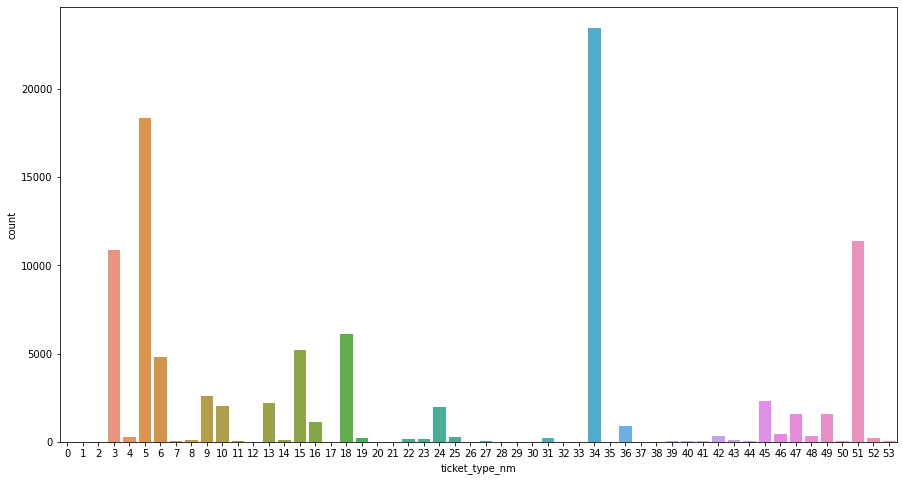

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(x = "ticket_type_nm" , data  = df);

In [ ]:
# Кажется нет четкой зависимости между категорией билета и временем между заходи на станцию

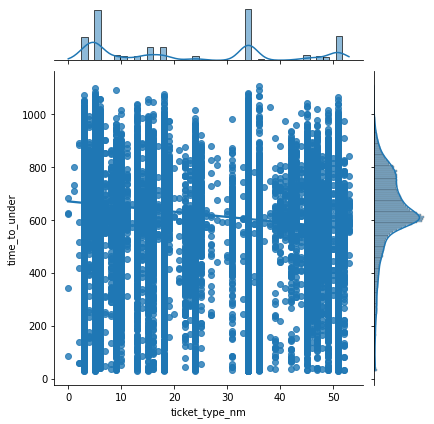

In [ ]:
sns.jointplot(x = "ticket_type_nm", y = 'time_to_under', data = df, kind = 'reg');

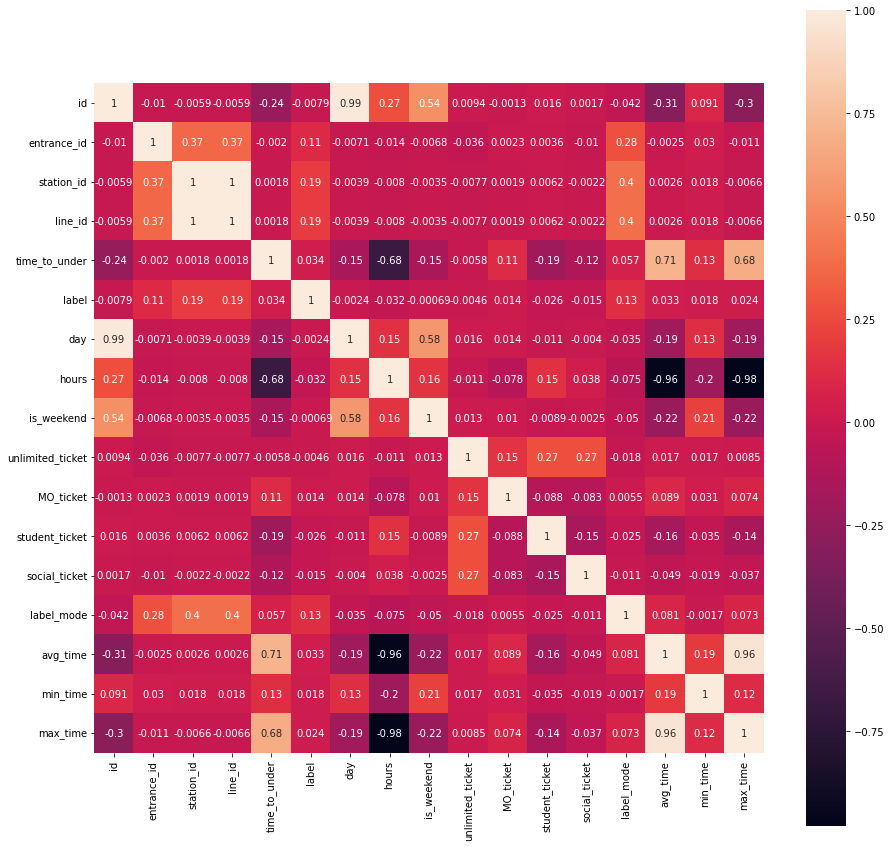

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

corr = df.corr()
g = sns.heatmap(corr, square = True, annot=True);

In [146]:
# df = pd.read_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared.csv', index_col = 0)
# df.head()

In [92]:
df_stations = pd.read_csv('/content/drive/MyDrive/stations.csv', index_col = 0)

In [93]:
df_stations

,0,longitude,latitude,distance_from_cremlin
0,Лефортово,37.705540,55.763539,5.601
1,Войковская,37.500220,55.818267,10.531
2,Аэропорт,37.534032,55.800150,7.606
3,Косино,37.895758,55.709330,18.010
4,Котельники,37.859411,55.674458,17.373
...,...,...,...,...
240,Выставочный центр,37.641221,55.821117,7.886
241,Улица Милашенкова,37.588591,55.822153,8.104
242,Улица Академика Королёва,37.641221,55.821117,7.886
243,Улица Эйзенштейна,37.641609,55.821110,7.889


In [28]:
def geolocation(adress: str):
    location = geocode(adress, provider='nominatim', user_agent='my_request')
    point = location.geometry.iloc[0]
    return (point.x, point.y)

In [ ]:
geolocation('метро Лефортово')

(37.7055395, 55.7635386)

In [ ]:
temp.tail(10)

,0,longitude,latitude,Distance_from_Cremlin,x
235,Сретенский бульвар,37.784933,55.763539,2422.65,метро Сретенский бульвар
236,Белокаменная,37.784933,55.763539,2422.65,метро Белокаменная
237,Боровицкая,37.784933,55.763539,2422.65,метро Боровицкая
238,Крестьянская застава,37.784933,55.763539,2422.65,метро Крестьянская застава
239,ЗИЛ,37.784933,55.763539,2422.65,метро ЗИЛ
240,Выставочный центр,37.784933,55.763539,2422.65,метро Выставочный центр
241,Улица Милашенкова,37.784933,55.763539,2422.65,метро Улица Милашенкова
242,Улица Академика Королёва,37.784933,55.763539,2422.65,метро Улица Академика Королёва
243,Улица Эйзенштейна,37.784933,55.763539,2422.65,метро Улица Эйзенштейна
244,Телецентр,37.784933,55.763539,2422.65,метро Телецентр


In [45]:
# temp['x'] = temp[0].apply(lambda x: 'метро ' + x)
# temp['longitude'] = temp['x'].apply(lambda x: geolocation(x))

In [ ]:
# df['longitude'] = geolocation('метро ' + df['station_nm'])[0]
# df['latitude'] = geolocation('метро ' + df['station_nm'])[1]

In [46]:
# temp = pd.DataFrame(df.station_nm.unique())
# temp

In [ ]:
stations = pd.DataFrame()

In [154]:
# Панфиловская
# 55 ° 47′57 ″ с.ш., 37 ° 29′56 ″ в.д.
# Спартак
# 55.8176765 северной широты и 37.4345436
# Трубная
#  55 ° 46'08 ″ N 37 ° 37'12 ″ E / 55,7688 ° N 37,6200 ° E.
# ЦСКА
#  55 ° 47'12 ″ N 37 ° 32′00 ″ E / 55,7866 ° N 37,5333 ° E / 55,78
#  Баррикадная	
#  55.76027	37.58111
# Крымская 
# 55 ° 41′25 ″ N 37 ° 36′15 ″ E / 55.6904 ° N 37.6042 ° E / 55.6904;
# Студенческая
# 55°44′20″ с. ш. 37°32′54″ в. д. 
# Арбатская
# 	55.75228	37.60357
# Рижская	55.79222	37.63557
# Андроновка
#  55°44′28″ с. ш. 37°44′04″ в. д.﻿ / ﻿55.741111° с. ш. 37.734444° 
# Белокаменная
#   55°49′48″ с. ш. 37°42′02″ 

In [37]:
lat = []
long = []
for station in temp[0]:
  print(station)
  if station == 'Панфиловская':
    long.append(37.4988889)
    lat.append(55.7991667)
  elif station == 'Спартак':
    long.append(37.4345436)
    lat.append(55.8176765)
  elif station == 'Трубная':
    long.append(37.6200000)
    lat.append(55.7688889)
  elif station == 'ЦСКА':
    long.append(37.5333333)
    lat.append(55.7866667)
  elif station == 'Баррикадная':
    long.append(37.5811111)
    lat.append(55.7602700)
  elif station == 'Крымская':
    long.append(37.605122°)
    lat.append(55.690004)
  elif station == 'Студенческая':
    long.append(37.5483333)
    lat.append(55.7388889)
  elif station == 'Арбатская':
    long.append(37.6035700)
    lat.append(55.7522800)
  elif station == 'Рижская':
    long.append(37.6355700)
    lat.append(55.7922200)
  elif station == 'Андроновка':
    long.append(37.7344444)
    lat.append(55.7411111)
  elif station == 'Белокаменная':
    long.append(37.7055556)
    lat.append(55.8300000)
  else:
    # stations['longitude'] = geolocation('метро ' + station)[0]
    # stations['latitude'] = geolocation('метро ' + station)[0]
    long.append(geolocation('метро ' + station)[0])
    lat.append(geolocation('метро ' + station)[1])

Лефортово
Войковская
Аэропорт
Косино


KeyboardInterrupt: ignored

In [89]:
# temp['longitude'] = long
# temp['latitude'] = lat

In [90]:
# df_stations.loc[df_stations['longitude'] == 30.2808503]

In [91]:
# temp.loc[temp['longitude'] == -118.121276]

In [92]:
# df_stations['0']

In [93]:
# df_stations.latitude.min()

In [13]:
# df_stations.loc[df_stations['longitude'] >= 38]

In [94]:
df_stations.loc[df_stations['0'] == 'Марьино', 'longitude'] = 37.74771
df_stations.loc[df_stations['0'] == 'Марьино', 'latitude'] = 55.651930
df_stations.loc[df_stations['0'] == 'ЗИЛ', 'longitude'] = 37.6474
df_stations.loc[df_stations['0'] == 'ЗИЛ', 'latitude'] = 55.6977778
df_stations.loc[df_stations['0'] == 'Ленинский проспект', 'longitude'] = 37.58742
df_stations.loc[df_stations['0'] == 'Ленинский проспект', 'latitude'] = 55.70818
df_stations.loc[df_stations['0'] == 'Балтийская', 'longitude'] = 37.494728
df_stations.loc[df_stations['0'] == 'Балтийская', 'latitude'] = 55.825153
df_stations.loc[df_stations['0'] == 'Киевская', 'longitude'] = 37.565587
df_stations.loc[df_stations['0'] == 'Киевская', 'latitude'] = 55.743588
df_stations.loc[df_stations['0'] == 'Чкаловская', 'longitude'] = 37.658006
df_stations.loc[df_stations['0'] == 'Чкаловская', 'latitude'] = 55.755809
df_stations.loc[df_stations['0'] == 'Международная', 'longitude'] = 37.534263
df_stations.loc[df_stations['0'] == 'Международная', 'latitude'] = 55.748311
df_stations.loc[df_stations['0'] == 'Локомотив', 'longitude'] = 37.745969
df_stations.loc[df_stations['0'] == 'Локомотив', 'latitude'] = 55.804056
df_stations.loc[df_stations['0'] == 'Волжская', 'longitude'] = 37.753164
df_stations.loc[df_stations['0'] == 'Волжская', 'latitude'] = 55.690902
df_stations.loc[df_stations['0'] == 'Пушкинская', 'longitude'] = 37.603900
df_stations.loc[df_stations['0'] == 'Пушкинская', 'latitude'] = 55.765752
df_stations.loc[df_stations['0'] == 'Площадь Революции', 'longitude'] = 37.622729
df_stations.loc[df_stations['0'] == 'Площадь Революции', 'latitude'] = 55.756807
df_stations.loc[df_stations['0'] == 'Зорге', 'longitude'] = 37.504223
df_stations.loc[df_stations['0'] == 'Зорге', 'latitude'] = 55.789158
df_stations.loc[df_stations['0'] == 'Крымская', 'longitude'] = 37.605122
df_stations.loc[df_stations['0'] == 'Крымская', 'latitude'] = 55.690004

In [81]:
# KREMLIN_LAT = [55.751410] * len(df_stations['latitude'])
# KREMLIN_LONG = [37.618960] * len(df_stations['longitude'])

In [ ]:
# temp.longitude = temp.longitude.apply(lambda x: round(x, 7))
# temp.latitude = temp.latitude.apply(lambda x: round(x, 7))

In [96]:
KREMLIN_LATITUDE = 55.751410
KREMLIN_LONGITUDE = 37.618960

In [97]:
df_stations['distance_from_cremlin'] = [round(geodesic((df_stations['latitude'][row],
                                       df_stations['longitude'][row]), (KREMLIN_LATITUDE, KREMLIN_LONGITUDE)).km, 3)
                       for row in range(len(df_stations['latitude']))]

In [74]:
# for row in range(len(df_stations['0'])):
#   print(df_stations['longitude'][row], df_stations['latitude'][row], KREMLIN_LATITUDE, KREMLIN_LONGITUDE)
#   print(geodesic((df_stations['longitude'][row], df_stations['latitude'][row]), (KREMLIN_LATITUDE, KREMLIN_LONGITUDE)).km)

In [105]:
# df_stations = df_stations.drop(['Distance_from_Cremlin'], axis = 1)
df_stations = df_stations.drop(['longitude', 'latitude'], axis = 1)

In [95]:
df_stations.head(3)

,0,longitude,latitude,distance_from_cremlin
0,Лефортово,37.705540,55.763539,5.601
1,Войковская,37.500220,55.818267,10.531
2,Аэропорт,37.534032,55.800150,7.606


In [147]:
df = df.merge(df_stations, left_on=['station_nm'], right_on=['0'])
df_test = df_test.merge(df_stations, left_on=['station_nm'], right_on=['0'])

In [148]:
# df = df.rename(columns={"distance_from_cremlin_x": "distance_from_cremlin"})
# df = df.drop(['distance_from_cremlin_y'], axis = 1)

In [149]:
df.head(3)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id_x,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,zone_station_2,0,longitude,latitude,distance_from_cremlin
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.100000,216.316667,1,1,Лефортово,37.70554,55.763539,5.601
1,381030,95C1631FC6215224502623DE9A9C4361,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 07:34:02,30.750000,8001,14,7,2022-09-14,0,0,0,0,0,7007,506.152431,30.750000,824.600000,1,1,Лефортово,37.70554,55.763539,5.601
2,145565,972CA322E0D1226BF9E4DAB0C6263B04,Социальная карта жителя Моск. области,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 12:48:31,509.800000,8001,12,12,2022-09-12,0,1,0,0,1,11009,347.172222,39.883333,667.116667,1,1,Лефортово,37.70554,55.763539,5.601


In [150]:
df = df.drop(['0'], axis = 1)
df_test = df_test.drop(['0'], axis = 1)

df = df.rename(columns={"longitude": "longitude_1", "latitude": "latitude_1", "station_id_x": "station_id"})
df_test = df_test.rename(columns={"longitude": "longitude_1", "latitude": "latitude_1", "station_id_x": "station_id"})

In [153]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')

In [107]:
df.head(3)

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,zone_station_2,longitude_1,latitude_2,distance_from_cremlin
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.100000,216.316667,1,1,37.70554,55.763539,5.601
1,381030,95C1631FC6215224502623DE9A9C4361,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 07:34:02,30.750000,8001,14,7,2022-09-14,0,0,0,0,0,7007,506.152431,30.750000,824.600000,1,1,37.70554,55.763539,5.601
2,145565,972CA322E0D1226BF9E4DAB0C6263B04,Социальная карта жителя Моск. области,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 12:48:31,509.800000,8001,12,12,2022-09-12,0,1,0,0,1,11009,347.172222,39.883333,667.116667,1,1,37.70554,55.763539,5.601


In [108]:
# df_stations = pd.read_csv('/content/drive/MyDrive/stations.csv', index_col = 0)
# df_stations

In [152]:
df_stations_2 = pd.DataFrame(df.groupby(['station_id', 'station_nm'])['station_id'].min())

In [154]:
df_stations_2

,,station_id
station_id,station_nm,
1002,Бульвар Рокоссовского,1002
1003,Воробьёвы горы,1003
1004,Комсомольская,1004
1005,Красносельская,1005
1006,Красные Ворота,1006
...,...,...
81012,Говорово,81012
81013,Солнцево,81013
81014,Боровское шоссе,81014


In [155]:
df_stations_2 = df_stations_2.merge(df_stations, left_on=['station_nm'], right_on=['0'])
# df = df.merge(df_stations, left_on=['station_nm'], right_on=['0'])

In [156]:
df_stations_2 = df_stations_2.drop(['0'], axis = 1)

In [157]:
df_stations_2 = df_stations_2.rename(columns={"distance_from_cremlin": "distance_from_cremlin_second", "longitude": "longitude_2", "latitude": "latitude_2"})

In [158]:
df_stations_2

,station_id,longitude_2,latitude_2,distance_from_cremlin_second
0,1002,37.732885,55.815187,10.075
1,14006,37.732885,55.815187,10.075
2,1003,37.554526,55.705971,6.479
3,1004,37.657086,55.775299,3.578
4,5004,37.657086,55.775299,3.578
...,...,...,...,...
271,81012,37.417593,55.660714,16.193
272,81013,37.391083,55.649321,18.289
273,81014,37.368068,55.647149,19.586
274,81015,37.355157,55.639323,20.759


In [159]:
df = df.merge(df_stations_2, left_on=['label'], right_on=['station_id'])
# df_test = df_test.merge(df_stations_2, left_on=['label'], right_on=['station_id'])

In [160]:
sorted(df.columns.tolist())

['MO_ticket',
 'avg_time',
 'date',
 'day',
 'distance_from_cremlin',
 'distance_from_cremlin_second',
 'entrance_id',
 'entrance_nm',
 'hours',
 'id',
 'is_weekend',
 'label',
 'label_mode',
 'latitude_1',
 'latitude_2',
 'line_id',
 'line_nm',
 'longitude_1',
 'longitude_2',
 'max_time',
 'min_time',
 'pass_dttm',
 'social_ticket',
 'station_id_x',
 'station_id_y',
 'station_nm',
 'student_ticket',
 'ticket_id',
 'ticket_type_nm',
 'time_to_under',
 'unlimited_ticket',
 'zone_station_1',
 'zone_station_2']

In [161]:
df = df.drop(['station_id_y'], axis = 1)
df = df.rename(columns={"station_id_x": "station_id"})

In [164]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')
df_stations.to_csv('/content/drive/MyDrive/stations.csv')
df_stations_2.to_csv('/content/drive/MyDrive/stations_2.csv')

In [167]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_from_cremlin_second'].median()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "median_distance_from_cremlin_second"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [17]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_from_cremlin_second'].min()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "min_distance_from_cremlin_second"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [18]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_from_cremlin_second'].max()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "max_distance_from_cremlin_second"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [39]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_from_cremlin_second'].median()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "median_distance_from_cremlin_second_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [40]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_from_cremlin_second'].min()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "min_distance_from_cremlin_second_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [42]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_from_cremlin_second'].max()).reset_index()
temp = temp.rename(columns={"distance_from_cremlin_second": "max_distance_from_cremlin_second_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [168]:
df['distance_to_cremlin_diff'] = df['distance_from_cremlin'] - df['distance_from_cremlin_second']

In [169]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].median()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "median_distance_to_cremlin_diff"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [19]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].min()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "min_distance_to_cremlin_diff"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [20]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].max()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "max_distance_to_cremlin_diff"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [43]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].median()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "median_distance_to_cremlin_diff_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [44]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].min()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "min_distance_to_cremlin_diff_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [45]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_to_cremlin_diff'].max()).reset_index()
temp = temp.rename(columns={"distance_to_cremlin_diff": "max_distance_to_cremlin_diff_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [172]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')

In [174]:
df = df.set_index(df['id'], drop= True)
df_test = df_test.set_index(df_test['id'], drop= True)

In [175]:
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,zone_station_2,longitude_1,latitude_1,distance_from_cremlin,longitude_2,latitude_2,distance_from_cremlin_second,median_distance_from_cremlin_second,distance_to_cremlin_diff,_median_distance_to_cremlin_diff
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.720326,55.752327,6.366,6.366,-0.765,-0.765
169985,169985,EECA0DB8C5556CE0469E33A5F271EC78,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-13 05:09:19,159.300000,11007,13,5,2022-09-13,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765
339855,339855,4E94D9AD14B82D3BF1CA5FF2FBFEBEBC,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 05:24:36,144.183333,11007,14,5,2022-09-14,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765
508742,508742,F23D89C1BB41EA202A56EA687BC22418,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-15 05:31:24,47.116667,11009,15,5,2022-09-15,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765
836615,836615,EC54545DF96AD2A42400896E38305DF1,Социальная карта москвича,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-17 05:31:42,30.100000,3023,17,5,2022-09-17,0,1,0,0,1,11007,119.403333,30.1,216.316667,1,3,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765


In [191]:
# df_stations['distance_from_cremlin'] = [round(geodesic((df_stations['latitude'][row],
#                                        df_stations['longitude'][row]), (KREMLIN_LATITUDE, KREMLIN_LONGITUDE)).km, 3)
#                        for row in range(len(df_stations['latitude']))]


df['distance_between_stations'] = [round(geodesic((df['latitude_1'][row], df['longitude_1'][row]), 
                                                  (df['latitude_2'][row], df['longitude_2'][row])).km, 3)
                                  for row in df['id']]

In [192]:
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,zone_station_2,longitude_1,latitude_1,distance_from_cremlin,longitude_2,latitude_2,distance_from_cremlin_second,median_distance_from_cremlin_second,distance_to_cremlin_diff,_median_distance_to_cremlin_diff,distance_between_stations
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.720326,55.752327,6.366,6.366,-0.765,-0.765,1.556
169985,169985,EECA0DB8C5556CE0469E33A5F271EC78,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-13 05:09:19,159.300000,11007,13,5,2022-09-13,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765,0.000
339855,339855,4E94D9AD14B82D3BF1CA5FF2FBFEBEBC,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 05:24:36,144.183333,11007,14,5,2022-09-14,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765,0.000
508742,508742,F23D89C1BB41EA202A56EA687BC22418,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-15 05:31:24,47.116667,11009,15,5,2022-09-15,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765,2.077
836615,836615,EC54545DF96AD2A42400896E38305DF1,Социальная карта москвича,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-17 05:31:42,30.100000,3023,17,5,2022-09-17,0,1,0,0,1,11007,119.403333,30.1,216.316667,1,3,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765,2.077


In [193]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')

In [194]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_between_stations'].median()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "median_distance_between_stations"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [21]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_between_stations'].min()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "min_distance_between_stations"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [22]:
temp = pd.DataFrame(df.groupby(['is_weekend','hours','station_nm'])['distance_between_stations'].max()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "max_distance_between_stations"})
df = df.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['is_weekend', 'hours','station_nm'], right_on=['is_weekend', 'hours','station_nm'])

In [46]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_between_stations'].median()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "median_distance_between_stations_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [47]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_between_stations'].min()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "min_distance_between_stations_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [48]:
temp = pd.DataFrame(df.groupby(['ticket_type_nm', 'is_weekend','hours','station_nm'])['distance_between_stations'].max()).reset_index()
temp = temp.rename(columns={"distance_between_stations": "max_distance_between_stations_ticket_type"})
df = df.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])
df_test = df_test.merge(temp, left_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'], right_on=['ticket_type_nm', 'is_weekend', 'hours','station_nm'])

In [23]:
df.head()

,Unnamed: 0,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,day,hours,date,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,zone_station_2,longitude_1,latitude_1,distance_from_cremlin,longitude_2,latitude_2,distance_from_cremlin_second,median_distance_from_cremlin_second,distance_to_cremlin_diff,median_distance_to_cremlin_diff,distance_between_stations,median_distance_between_stations,median_zone_station_2,min_distance_from_cremlin_second,max_distance_from_cremlin_second,min_distance_to_cremlin_diff,max_distance_to_cremlin_diff,min_distance_between_stations,max_distance_between_stations
0,0,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001,12,5,2022-09-12,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.720326,55.752327,6.366,6.366,-0.765,-0.765,1.556,1.556,1.0,5.601,6.433,-0.832,0.0,0.0,2.077
1,1,EECA0DB8C5556CE0469E33A5F271EC78,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-13 05:09:19,159.300000,11007,13,5,2022-09-13,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765,0.000,1.556,1.0,5.601,6.433,-0.832,0.0,0.0,2.077
2,2,4E94D9AD14B82D3BF1CA5FF2FBFEBEBC,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-14 05:24:36,144.183333,11007,14,5,2022-09-14,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705540,55.763539,5.601,6.366,0.000,-0.765,0.000,1.556,1.0,5.601,6.433,-0.832,0.0,0.0,2.077
3,3,F23D89C1BB41EA202A56EA687BC22418,КОШЕЛЕК,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-15 05:31:24,47.116667,11009,15,5,2022-09-15,0,0,0,0,0,11007,119.403333,30.1,216.316667,1,1,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765,2.077,1.556,1.0,5.601,6.433,-0.832,0.0,0.0,2.077
4,4,EC54545DF96AD2A42400896E38305DF1,Социальная карта москвича,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-17 05:31:42,30.100000,3023,17,5,2022-09-17,0,1,0,0,1,11007,119.403333,30.1,216.316667,1,3,37.70554,55.763539,5.601,37.705700,55.782192,6.433,6.366,-0.832,-0.765,2.077,1.556,1.0,5.601,6.433,-0.832,0.0,0.0,2.077


In [49]:
df.to_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv')
df_test.to_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv')

In [33]:
df = pd.read_csv('/content/drive/MyDrive/moscow_metro_df_train_prepared2.csv', index_col = 'id')
df_test = pd.read_csv('/content/drive/MyDrive/moscow_metro_df_test_prepared2.csv', index_col = 'id')

In [50]:
df = df.drop(['Unnamed: 0', 'station_nm', 'ticket_id', 'ticket_type_nm', 'entrance_nm', 'line_nm', 'pass_dttm', 'date', 'distance_between_stations', 'distance_from_cremlin_second', 'distance_to_cremlin_diff', 'longitude_1', 'longitude_2', 'latitude_1', 'latitude_2', 'zone_station_2'], axis = 1)
df = pd.DataFrame(pd.get_dummies(data = df, columns = ['entrance_id', 'line_id']))

df_test = df_test.drop(['Unnamed: 0', 'station_nm', 'ticket_id', 'ticket_type_nm', 'entrance_nm', 'line_nm', 'pass_dttm', 'date'], axis = 1)
df_test = pd.DataFrame(pd.get_dummies(data = df_test, columns = ['entrance_id', 'line_id']))

In [213]:
df.head()

,station_id,time_to_under,label,day,hours,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone_station_1,distance_from_cremlin,median_distance_from_cremlin_second,median_distance_to_cremlin_diff,median_distance_between_stations,median_zone_station_2,entrance_id_20,entrance_id_21,entrance_id_23,entrance_id_24,entrance_id_26,entrance_id_27,entrance_id_29,entrance_id_31,entrance_id_33,entrance_id_35,entrance_id_36,entrance_id_38,entrance_id_40,entrance_id_41,entrance_id_43,entrance_id_44,entrance_id_47,entrance_id_48,entrance_id_52,entrance_id_54,entrance_id_55,entrance_id_58,entrance_id_60,entrance_id_61,entrance_id_63,entrance_id_64,entrance_id_66,entrance_id_67,entrance_id_69,entrance_id_70,entrance_id_72,entrance_id_73,entrance_id_75,entrance_id_76,entrance_id_78,entrance_id_79,entrance_id_81,entrance_id_82,entrance_id_84,entrance_id_85,entrance_id_87,entrance_id_88,entrance_id_90,entrance_id_92,entrance_id_96,entrance_id_98,entrance_id_100,entrance_id_101,entrance_id_103,entrance_id_104,entrance_id_106,entrance_id_107,entrance_id_109,entrance_id_110,entrance_id_112,entrance_id_113,entrance_id_115,entrance_id_116,entrance_id_118,entrance_id_127,entrance_id_130,entrance_id_132,entrance_id_134,entrance_id_135,entrance_id_139,entrance_id_141,entrance_id_143,entrance_id_145,entrance_id_147,entrance_id_148,entrance_id_150,entrance_id_151,entrance_id_153,entrance_id_154,entrance_id_156,entrance_id_157,entrance_id_159,entrance_id_161,entrance_id_164,entrance_id_166,entrance_id_167,entrance_id_169,entrance_id_170,entrance_id_172,entrance_id_173,entrance_id_175,entrance_id_176,entrance_id_178,entrance_id_179,entrance_id_181,entrance_id_182,entrance_id_184,entrance_id_185,entrance_id_187,entrance_id_188,entrance_id_190,entrance_id_191,entrance_id_193,entrance_id_195,entrance_id_198,entrance_id_200,entrance_id_201,entrance_id_203,entrance_id_205,entrance_id_207,entrance_id_209,entrance_id_211,entrance_id_213,entrance_id_215,entrance_id_217,entrance_id_218,entrance_id_220,entrance_id_221,entrance_id_223,entrance_id_225,entrance_id_227,entrance_id_229,entrance_id_231,entrance_id_233,entrance_id_234,entrance_id_236,entrance_id_237,entrance_id_239,entrance_id_240,entrance_id_242,entrance_id_243,entrance_id_245,entrance_id_246,entrance_id_248,entrance_id_250,entrance_id_252,entrance_id_254,entrance_id_256,entrance_id_258,entrance_id_259,entrance_id_262,entrance_id_264,entrance_id_266,entrance_id_267,entrance_id_269,entrance_id_270,entrance_id_272,entrance_id_273,entrance_id_275,entrance_id_276,entrance_id_278,entrance_id_279,entrance_id_281,entrance_id_282,entrance_id_284,entrance_id_285,entrance_id_287,entrance_id_288,entrance_id_290,entrance_id_291,entrance_id_293,entrance_id_296,entrance_id_297,entrance_id_298,entrance_id_300,entrance_id_301,entrance_id_303,entrance_id_304,entrance_id_306,entrance_id_307,entrance_id_309,entrance_id_310,entrance_id_312,entrance_id_313,entrance_id_315,entrance_id_318,entrance_id_320,entrance_id_322,entrance_id_324,entrance_id_325,entrance_id_327,entrance_id_328,entrance_id_330,entrance_id_331,entrance_id_333,entrance_id_334,entrance_id_336,entrance_id_337,entrance_id_339,entrance_id_340,entrance_id_342,entrance_id_343,entrance_id_345,entrance_id_346,entrance_id_348,entrance_id_349,entrance_id_351,entrance_id_352,entrance_id_354,entrance_id_355,entrance_id_357,entrance_id_358,entrance_id_362,entrance_id_364,entrance_id_366,entrance_id_368,entrance_id_370,entrance_id_372,entrance_id_374,entrance_id_376,entrance_id_378,entrance_id_380,entrance_id_381,entrance_id_383,entrance_id_384,entrance_id_386,entrance_id_388,entrance_id_389,entrance_id_391,entrance_id_393,entrance_id_394,entrance_id_396,entrance_id_397,entrance_id_399,entrance_id_400,entrance_id_402,entrance_id_404,entrance_id_406,entrance_id_408,entrance_id_410,entrance_id_412,entrance_id_413,entrance_id_415,entrance_id_416,entrance_id_418,entrance_id_419,entrance_id_421,entrance_id_422,entrance_id

In [51]:
## Выделим выборки

X = df.drop(['time_to_under', "label"], axis = 1)
y = df[["time_to_under", "label"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, stratify = y['label'])

In [52]:
df_stratified = pd.concat([X_test, y_test], axis = 1)

In [ ]:
# df_stratified.to_csv('/content/drive/MyDrive/df_stratified')

In [ ]:
# df_stratified = pd.read_csv("/content/drive/MyDrive/df_stratified", index_col=0)
# df_subway = pd.read_csv("/content/drive/MyDrive/subway.csv")

In [ ]:
# df_subway

In [ ]:
# df_subway.iloc[0:2]

In [ ]:
# df_subway['all_stations_nm'][0]

In [ ]:
# df_subway['all_stations_nm'][1]

In [ ]:
# df_stratified

In [ ]:
# df_stratified.columns.tolist()

In [53]:
## Выделим выборки

X = df_stratified.drop(["label","time_to_under"], axis = 1)
y = df_stratified[["time_to_under", "label"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)

y_train

,time_to_under,label
1039820,763.350000,10018
473730,681.866667,11021
117067,786.850000,9014
1036736,839.133333,3010
706866,465.250000,2008
...,...,...
1050986,548.333333,6008
207703,608.316667,10022
333997,550.016667,1019
3816,549.400000,2013


In [ ]:
## Обучение модели

# Для станции 

clf = RandomForestClassifier(random_state=0)

clf.fit(X_train, y_train["label"])

RandomForestClassifier(random_state=0)

In [ ]:
# def cv_score(model_name, score, n_splits):
#     cv_split = KFold(n_splits = n_splits)
#     cv = cross_validate(model_name, X_train, y_train, scoring=score, cv=cv_split, return_train_score=True)
#     return (f'{score} on train cv: {cv["train_score"].mean()}   '
#             f'{score} on valid cv: {cv["test_score"].mean()}')

In [ ]:
# cv_score(clf, 'recall_score', 4)
pred_class = clf.predict(X_test)
recall_score(y_test["label"], pred_class , average='macro')

0.03240380429115898

In [ ]:
X_train

,entrance_id,station_id,line_id,day,hours,is_weekend,unlimited_ticket,MO_ticket,student_ticket,social_ticket,label_mode,avg_time,min_time,max_time,zone
388783,154,3022,3,16,7,0,0,0,0,0,3002,637.928173,31.416667,1003.866667,1
705810,273,6016,6,15,9,0,1,0,0,1,6020,558.956240,32.066667,867.800000,1
768496,333,7011,7,14,12,0,0,0,0,0,7023,294.642136,34.283333,656.716667,2
1002628,349,9001,9,13,8,0,1,0,0,0,9007,571.552133,42.516667,951.816667,1
180239,297,7004,7,12,7,0,1,0,0,0,7020,632.313602,33.283333,993.633333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690812,418,10002,10,15,9,0,1,0,0,0,10007,555.960609,30.250000,881.433333,1
999120,349,9001,9,17,5,0,0,0,0,0,9008,665.133333,75.816667,1060.600000,1
638418,2153,14028,14,14,8,0,1,0,0,1,14011,597.615608,37.333333,910.350000,2
242505,26,1011,1,12,11,0,1,0,0,0,5010,403.951868,38.816667,759.533333,2


In [ ]:
print("train recall:", recall_score(y_train["label"], clf.predict(X_train) , average='macro'))
print("valid recall:", recall_score(y_test["label"], clf.predict(X_test) , average='macro'))

train recall: 0.21892987853282608
valid recall: 0.05257378170194927


In [ ]:
print("valid recall:", recall_score(y_test["label"], X_test['label_mode'], average='macro'))

valid recall: 0.05994287507942848


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Для времени

reg = RandomForestRegressor(random_state=0)

reg.fit(X_train, y_train["time_to_under"])

RandomForestRegressor(random_state=0)

In [ ]:
## Оценка точности

pred_class = clf.predict(X_test)
pred_reg = reg.predict(X_test)

from sklearn.metrics import recall_score, r2_score

label_score = recall_score(y_test["label"], pred_class , average='macro')
time_score = r2_score(y_test["time_to_under"], pred_reg)
score = 0.5 * label_score +  0.5 * time_score
print(f'label score: {np.round(label_score,3)}, time score: {np.round(time_score,3)}, total score: {np.round(score,3)}')

label score: 0.041, time score: 0.424, total score: 0.233


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 89 kB 3.8 MB/s 


In [ ]:
from skmultilearn.model_selection import IterativeStratification

k_fold = IterativeStratification(n_splits=2, order=1)
for train, test in k_fold.split(X, y):
    clf.fit(X[train], y[train])
    result = clf.predict(X[test])


KeyError: ignored

In [60]:
cb = CatBoostClassifier(iterations = 50)
    # iterations = 1000,
    #                     learning_rate=0.5,
    #                     depth=4,
    #                     l2_leaf_reg=0.1,
    #                     rsm=None,
    #                     loss_function='RMSE')

cb.fit(X_train, y_train['label'])

Learning rate set to 0.5
0:	learn: 5.2937912	total: 5.24s	remaining: 4m 16s
1:	learn: 5.1633096	total: 10.3s	remaining: 4m 6s
2:	learn: 5.0203210	total: 15.1s	remaining: 3m 56s
3:	learn: 4.9235742	total: 20.1s	remaining: 3m 50s
4:	learn: 4.8542628	total: 25s	remaining: 3m 45s
5:	learn: 4.7990540	total: 29.9s	remaining: 3m 39s
6:	learn: 4.7456843	total: 34.8s	remaining: 3m 33s
7:	learn: 4.7041660	total: 39.7s	remaining: 3m 28s
8:	learn: 4.6620774	total: 44.6s	remaining: 3m 23s
9:	learn: 4.6377526	total: 49.5s	remaining: 3m 17s
10:	learn: 4.5960472	total: 54.4s	remaining: 3m 12s
11:	learn: 4.5692267	total: 59.3s	remaining: 3m 7s
12:	learn: 4.5487943	total: 1m 4s	remaining: 3m 2s
13:	learn: 4.5118338	total: 1m 9s	remaining: 2m 57s
14:	learn: 4.4686693	total: 1m 14s	remaining: 2m 52s
15:	learn: 4.4218710	total: 1m 19s	remaining: 2m 48s
16:	learn: 4.3846233	total: 1m 24s	remaining: 2m 43s
17:	learn: 4.3609393	total: 1m 28s	remaining: 2m 38s
18:	learn: 4.3175906	total: 1m 33s	remaining: 2m 3

In [62]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 25.5 MB/s 
     |████████████████████████████████| 81 kB 9.8 MB/s 
     |████████████████████████████████| 209 kB 66.9 MB/s 
     |████████████████████████████████| 78 kB 8.0 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 147 kB 69.1 MB/s 
     |████████████████████████████████| 112 kB 65.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a8ddb54cf1912ea1b2b1d1dda17c4cf3c5b0f3a143b6bdc8d7ba666f2dd88b19
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [80]:
import optuna
def objective(trial):
    # train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.3)
  # X_train, X_test, y_train, y_test
    param = {
        # "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        # "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        # "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        
        "iterations": trial.suggest_int("iterations", 20,100),
        'learning_rate': trial.suggest_float("learning_rate", 0.1, 0.5),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0.01, 0.5),
        'depth': trial.suggest_int("depth", 5, 16),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 0, 0.5),
        "used_ram_limit": "10gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    cbr = CatBoostRegressor(**param)

    cbr.fit(X_train, y_train['time_to_under'], eval_set=[(X_test, y_test['time_to_under'])], verbose=0, early_stopping_rounds=100)

    preds = cbr.predict(X_test)
    pred_labels = np.rint(preds)
    r2 = r2_score(y_test['time_to_under'], pred_labels)
    return r2

In [81]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-11-16 13:28:40,997] A new study created in memory with name: no-name-22b769c3-6d72-47bf-a11f-93c90ca1dde7
[I 2022-11-16 13:29:15,227] Trial 0 finished with value: 0.5823007755556047 and parameters: {'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'iterations': 20, 'learning_rate': 0.3573010927577174, 'l2_leaf_reg': 0.30919292668659054, 'depth': 11}. Best is trial 0 with value: 0.5823007755556047.
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:656: RuntimeWarning: Inconsistent parameter values for distribution with name "l2_leaf_reg"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.5, 'log': False}
  RuntimeWarning,
[I 2022-11-16 13:29:21,086] Trial 1 finished with value: 0.5774445809205472 and parameters: {'

CatBoostError: ignored

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [61]:
print("train recall:", recall_score(y_train["label"], cb.predict(X_train) , average='macro'))
print("valid recall:", recall_score(y_test["label"], cb.predict(X_test) , average='macro'))

train recall: 0.24914946385953787
valid recall: 0.07068622210943774


In [ ]:
train recall: 0.032406612255517796
valid recall: 0.031043779821961076

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/test_dataset_test.csv')

In [ ]:
df_test

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm
0,1091022,425A13E16226CA01032043111488E0F5,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03
1,1091023,F94EDC107A4E054786882F9453C1B93F,Пропуск FacePay,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45
2,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,СК студента 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52
3,1091025,7B98691636EC418ABF6FEDDE4D7C68FC,КОШЕЛЕК,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58
4,1091026,679C55C28CB36FB546FD104502C0B3DB,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39
...,...,...,...,...,...,...,...,...,...,...
561885,1652907,B6FADEB8705FAF8E9DFD9016A613D997,Пропуск FacePay,279,Калужская (Южный),6007,Калужская,6,Калужско-Рижская,2022-09-19 01:33:11
561886,1652908,77F2868FC2648ACCBD58F1F8AB66C321,Пропуск FacePay,2463,Кунцевская БКЛ (Первый),11020,Кунцевская,11,Большая кольцевая,2022-09-19 02:03:59
561887,1652909,29A4ACF592877817B8D00D969DFDB681,Пропуск FacePay,64,Проспект Вернадского ( Южный ),1012,Проспект Вернадского,1,Сокольническая,2022-09-19 02:51:34
561888,1652910,DE9EBEFD0DF4A351013AA574B075F535,Пропуск FacePay,285,Коньково (Южный),6009,Коньково,6,Калужско-Рижская,2022-09-19 02:58:10


In [ ]:
pd.DataFrame(cb.predict(X_test)).to_csv('')

In [ ]:
y_test["label"].head(20)

722772     81011
975011      2014
533996      6008
549988      5010
872490      5005
712841      2014
652424      6015
46248       7015
612504      8001
857430      9014
179410      7022
859870      1024
425597      6020
628314     10004
285133      9018
883627      1011
173071      1014
137671     81003
292293     10020
1058289     1009
Name: label, dtype: int64

In [ ]:
y_train

,time_to_under,label
1068526,633.566667,14009
148353,547.983333,10021
585118,806.450000,2021
930609,785.216667,1009
537540,650.466667,6022
...,...,...
114961,532.100000,7011
1035011,239.000000,6003
564345,303.216667,9018
494106,721.933333,1008


In [56]:
cb_reg = CatBoostRegressor(iterations = 100)
cb_reg.fit(X_train, y_train['time_to_under'])

Learning rate set to 0.448779
0:	learn: 185.8943387	total: 12.1ms	remaining: 1.2s
1:	learn: 164.8867240	total: 24.1ms	remaining: 1.18s
2:	learn: 156.7551054	total: 35.9ms	remaining: 1.16s
3:	learn: 153.6460892	total: 47.1ms	remaining: 1.13s
4:	learn: 152.2800879	total: 63.3ms	remaining: 1.2s
5:	learn: 151.6676824	total: 74.2ms	remaining: 1.16s
6:	learn: 151.2922274	total: 86.8ms	remaining: 1.15s
7:	learn: 150.9894867	total: 104ms	remaining: 1.19s
8:	learn: 150.9243243	total: 115ms	remaining: 1.16s
9:	learn: 150.7574542	total: 127ms	remaining: 1.14s
10:	learn: 150.6411341	total: 138ms	remaining: 1.11s
11:	learn: 150.5083766	total: 149ms	remaining: 1.09s
12:	learn: 150.4589334	total: 163ms	remaining: 1.09s
13:	learn: 150.3733231	total: 174ms	remaining: 1.07s
14:	learn: 150.2842529	total: 184ms	remaining: 1.04s
15:	learn: 150.1618648	total: 196ms	remaining: 1.03s
16:	learn: 150.1035621	total: 210ms	remaining: 1.03s
17:	learn: 149.9009886	total: 230ms	remaining: 1.05s
18:	learn: 149.777700

In [57]:
print("train recall:", r2_score(y_train["time_to_under"], cb_reg.predict(X_train)))
print("valid recall:", r2_score(y_test["time_to_under"], cb_reg.predict(X_test)))

train recall: 0.6344212278854692
valid recall: 0.5753978915282782


In [59]:
X_train.columns.tolist()

['station_id',
 'day',
 'hours',
 'is_weekend',
 'unlimited_ticket',
 'MO_ticket',
 'student_ticket',
 'social_ticket',
 'label_mode',
 'avg_time',
 'min_time',
 'max_time',
 'zone_station_1',
 'distance_from_cremlin',
 'median_distance_from_cremlin_second',
 'median_distance_to_cremlin_diff',
 'median_distance_between_stations',
 'median_zone_station_2',
 'label_mode_ticket_type',
 'avg_time_ticket_type',
 'min_time_ticket_type',
 'max_time_ticket_type',
 'median_zone_station_2_ticket_type',
 'median_distance_from_cremlin_second_ticket_type',
 'min_distance_from_cremlin_second_ticket_type',
 'max_distance_from_cremlin_second_ticket_type',
 'median_distance_to_cremlin_diff_ticket_type',
 'min_distance_to_cremlin_diff_ticket_type',
 'max_distance_to_cremlin_diff_ticket_type',
 'median_distance_between_stations_ticket_type',
 'min_distance_between_stations_ticket_type',
 'max_distance_between_stations_ticket_type',
 'entrance_id_20',
 'entrance_id_21',
 'entrance_id_23',
 'entrance_id_24

In [58]:
cb_reg.feature_importances_

array([3.10539969e-01, 1.81497814e+00, 3.38996632e-01, 1.62683314e-01,
       2.91902224e-01, 0.00000000e+00, 3.93520676e-01, 1.95669957e-01,
       5.25046250e-01, 1.23056847e+00, 1.26525565e+00, 7.39481719e-01,
       1.42151386e-01, 3.20639858e-01, 8.98132351e-01, 7.46531520e-01,
       2.58402886e-01, 3.89062231e-02, 1.88435227e+00, 7.10829939e+01,
       3.04942122e+00, 2.43042380e+00, 1.01691981e-01, 9.10783606e-01,
       9.92571343e-01, 5.77940031e-01, 6.85658450e-01, 1.14568223e+00,
       3.25119545e-01, 4.99709500e-01, 1.21861003e+00, 1.13876748e+00,
       0.00000000e+00, 0.00000000e+00, 1.13702796e-03, 0.00000000e+00,
       0.00000000e+00, 2.45444618e-02, 5.03952243e-02, 0.00000000e+00,
       4.19028851e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.98540339e-03, 0.00000000e+00,
       1.41555178e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.49745143e-02, 0.00000000e+00, 1.88214951e-02, 0.00000000e+00,
      

In [ ]:
cb_scores = model_selection.cross_val_score(cb, X, y, cv=5, scoring = 'neg_mean_squared_error')
np.mean(np.sqrt(-cb_scores))

In [ ]:
LGBM = LGBMClassifier()

In [ ]:
LGBM.fit(X_train, y_train['label'])

LGBMClassifier()

In [ ]:
print("train recall:", recall_score(y_train["label"], LGBM.predict(X_train) , average='macro'))
print("valid recall:", recall_score(y_test["label"], LGBM.predict(X_test) , average='macro'))

train recall: 0.019275297341081663
valid recall: 0.0077826762385944685


In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
GNB = GaussianNB()

GNB.fit(X_train, y_train['label'])

GaussianNB()

In [ ]:
print("train recall:", recall_score(y_train["label"], GNB.predict(X_train) , average='macro'))
print("valid recall:", recall_score(y_test["label"], GNB.predict(X_test) , average='macro'))

train recall: 0.04479047415650402
valid recall: 0.01869887300093716


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
